<a href="https://colab.research.google.com/github/elmomote/DL2024-FacialKeypointDetectionProject/blob/main/%5BF24_DL%5D_Facial_Keypoint_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Final Project: Facial Keypoint Detection**
### *Authored by: Anaiah Quinn and Alan Gonzales*
####*Date: December 11th 2024*

GOAL: Train a neural network to accurately identify and locate key facial keypoints  (left eye center, right eyebrow inner end, mouth right corner, etc.) in images.,

To better experiment alternate solutions, we each worked on a different model then later combined their strengths to develop the final model.

# Loading Data set from Kaggle

Disclaimer: We sourced the data set from kaggle.com. In order to access that data and run the code, a kaggle api token must be downloaded using a kaggle account and then uploaded below. For that reason, all outputs are shown below

In [1]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c facial-keypoints-detection
!unzip facial-keypoints-detection.zip
!unzip training.zip
!unzip test.zip


Saving kaggle.json to kaggle.json
 76% 58.0M/76.3M [00:00<00:00, 85.9MB/s]
100% 76.3M/76.3M [00:00<00:00, 91.2MB/s]
Archive:  facial-keypoints-detection.zip
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    
  inflating: test.zip                
  inflating: training.zip            
Archive:  training.zip
  inflating: training.csv            
Archive:  test.zip
  inflating: test.csv                


## Sample Image

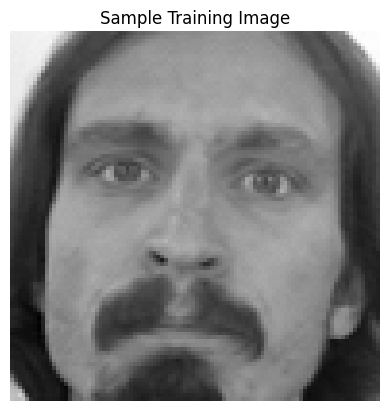

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
image_index = 0  # Change this to display a different image
image = data['Image'][image_index].reshape(96, 96)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Sample Training Image")
plt.show()


## Sample Image with Key points

In [ ]:
keypoints = data.iloc[image_index, :-1].values  # All columns except the 'Image'
keypoints = keypoints.astype(float).reshape(-1, 2)  # Reshape into (x, y) pairs

plt.imshow(image, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, c='red', marker='o')
plt.axis('off')
plt.title("Training Image with Keypoints")
plt.show()


# Model 1
Conducted by Anaiah Quinn

Preparing the data by Removing null Key Points from data sets,
Normalizing Keypoints, and spliting the training data 80% training, 20% validation.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Process Data from csv file
# Load and preprocess data
data = pd.read_csv('training.csv')
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
data.dropna(inplace=True)  # Drop rows with missing keypoints


images = np.stack(data['Image'].values).reshape(-1, 96, 96, 1) / 255.0  # Normalize pixel values
keypoints = data.drop(columns=['Image']).values/96.0  # Keypoints as targets, normalized

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, keypoints, test_size=0.2, random_state=42)



### Attempt 1
 Here I am creating a Convolutional Neural Network model with filters 32 and 64 that implements dropout layers with a 20% drop rate and use max pooling for reducing dimensions in between convolutional layers.




In [ ]:
def first_model():
  model = tf.keras.Sequential()
  model.add(Input(shape=(96, 96, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.20))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.50))
  model.add(Dense(30))
  model.summary()

  return model

Here I compiled the model with MSE(Mean Squared Error) as the loss function to heavily penalizes large errors, guiding the model towards better overall accuracy.
I used MAE(Mean Absolute Error) as a metric because it provides an easily interpretable measure of average prediction error, less sensitive to outliers than MSE.

In [ ]:
model = first_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,987,742 (15.21 MB)

 Trainable params: 3,987,742 (15.21 MB)

 Non-trainable params: 0 (0.00 B)

Training the model with the obtained training and validation data.

In [ ]:
from tensorflow.keras.callbacks import  *
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
# Compile the model
model = first_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es]
                    )

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,987,742 (15.21 MB)

 Trainable params: 3,987,742 (15.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 561ms/step - loss: 0.0198 - mae: 0.1097 - val_loss: 0.0074 - val_mae: 0.0707
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - loss: 0.0056 - mae: 0.0591 - val_loss: 0.0045 - val_mae: 0.0544
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - loss: 0.0038 - mae: 0.0488 - val_loss: 0.0054 - val_mae: 0.0604
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 522ms/step - loss: 0.0031 - mae: 0.0433 - val_loss: 0.0049 - val_mae: 0.0580
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - loss: 0.0027 - mae: 0.0407 - val_loss: 0.0024 - val_mae: 0.0390
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 490ms/step - loss: 0.0024 - mae: 0.0381 - val_loss: 0.0037 - val_mae: 0.0497
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 546ms/step - loss: 0.0022 - mae: 0.0359 - val_loss: 0.0025 - val_mae: 0.0404
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - loss: 0.0021 - mae: 0.0349 - val_loss: 0.0021 - val_mae: 0.0367
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 497ms/

Function to visualize the models predicted keypoints and compare them to the true keypoints.

In [ ]:
# Visualize predictions
def visualize_predictions(index):
    img = X_val[index].reshape(96, 96)
    true_keypoints = y_val[index].reshape(-1, 2)*96 # rescale
    predicted_keypoints = model.predict(X_val[index:index+1]).reshape(-1, 2)*96 # rescale

    plt.imshow(img, cmap='gray')
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], c='green', label='True', s=20)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='red', label='Predicted', s=20)
    plt.legend()
    plt.title('True vs Predicted Keypoints')
    #plt.axis('off')
    plt.show()

Plotting the training history for the first model

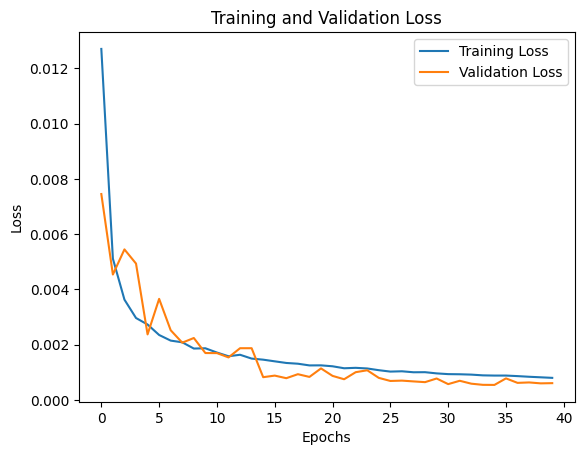

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 5.7265e-04 - mae: 0.0172
Validation Loss: 0.0005, Validation MAE: 0.0168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


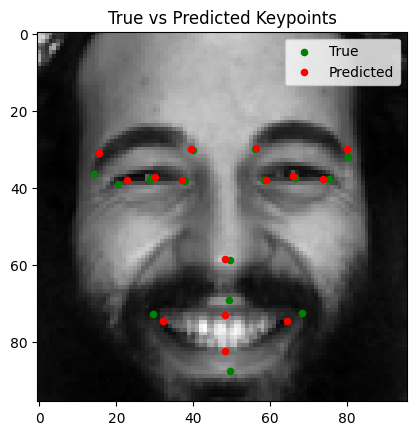

In [ ]:
# Plotting training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
# Visualizing the predictions for the first image
visualize_predictions(0)



Observed decent visual accuracy of predicted keypoints in red as many overlapped with their true keypoint counterpart in green. Decided to display more predictions at random below.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


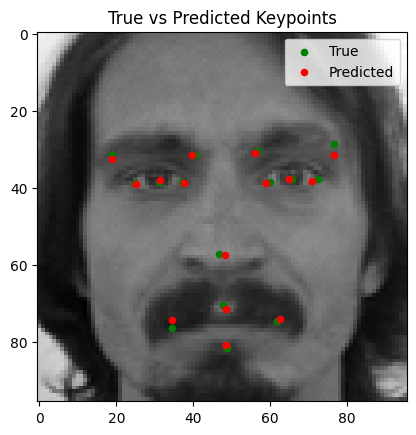

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


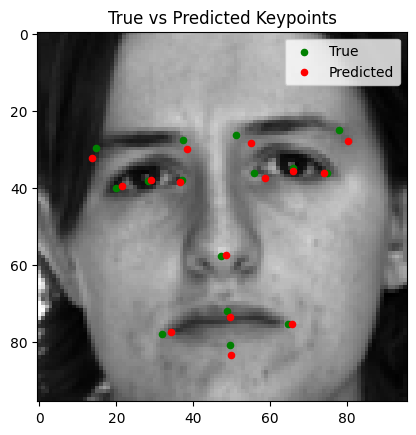

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


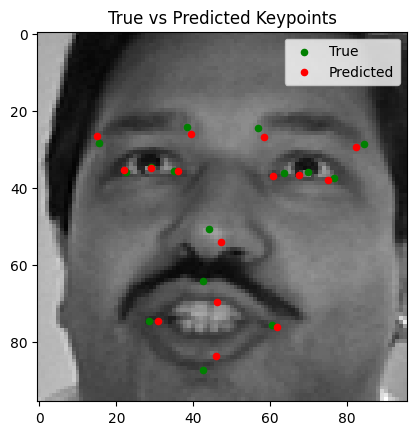

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


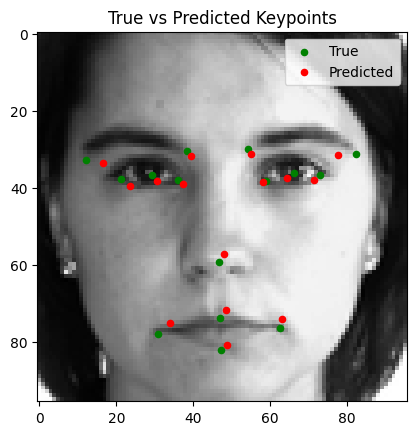

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


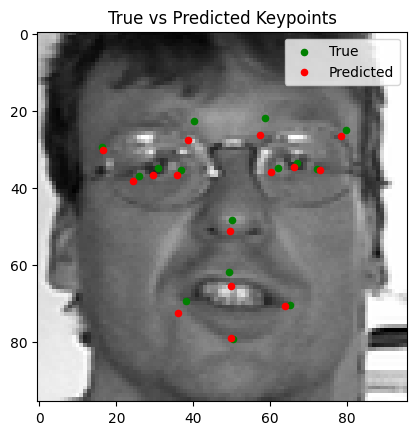

In [ ]:
# random index
import random
random_indices = np.random.choice(len(X_val), size = 5)
for index in random_indices:
  visualize_predictions(index)

### Attempt 2
Same architecure as attempt 1 but with the removal of the dropout layers.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,987,742 (15.21 MB)

 Trainable params: 3,987,742 (15.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - loss: 0.0735 - mae: 0.1842 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - loss: 0.0015 - mae: 0.0291 - val_loss: 9.3389e-04 - val_mae: 0.0229
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 440ms/step - loss: 8.4697e-04 - mae: 0.0217 - val_loss: 6.8879e-04 - val_mae: 0.0193
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 423ms/step - loss: 6.4072e-04 - mae: 0.0189 - val_loss: 6.5157e-04 - val_mae: 0.0189
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 469ms/step - loss: 5.5420e-04 - mae: 0.0175 - val_loss: 5.6595e-04 - val_mae: 0.0175
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 423ms/step - loss: 4.7423e-04 - mae: 0.0162 - val_loss: 5.6442e-04 - val_mae: 0.0174
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 472ms/step - loss: 4.7192e-04 - mae: 0.0163 - val_loss: 6.3707e-04 - val_mae: 0.0184
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 429ms/step - loss: 6.0537e-04 - mae: 0.0188 - val_loss: 5.0998e-04 - val_mae: 0.0

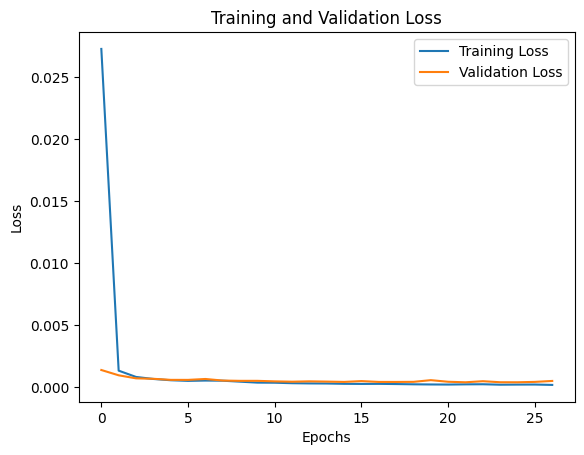

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 4.0303e-04 - mae: 0.0139
Validation Loss: 0.0004, Validation MAE: 0.0135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


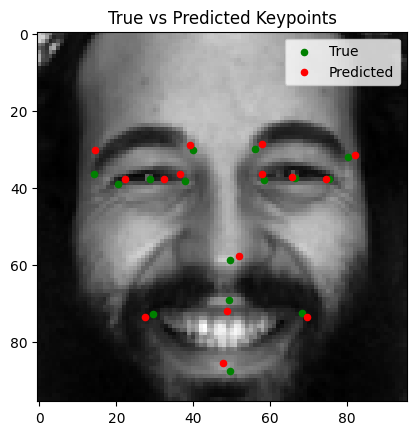

In [ ]:
#Attempt 2
def cnn_model():
  model = tf.keras.Sequential()
  model.add(Input(shape=(96, 96, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
 # model.add(Dropout(0.20))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  #model.add(Dropout(0.50))
  model.add(Dense(30))
  model.summary()

  return model

from tensorflow.keras.callbacks import  *
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
# Compile the model
model = cnn_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es]
                    )
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
visualize_predictions(0)

Attempt 2, removing the dropout layers improved the performance and decreased the error. This could possibly be because the dropout was suboptimal, elimnating key details.

### Attempt 3:
Same architecure as attempt one but with an additional convolutional layer of filter size 128

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,070 (6.62 MB)

 Trainable params: 1,735,070 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 563ms/step - loss: 0.0533 - mae: 0.1482 - val_loss: 0.0012 - val_mae: 0.0256
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 590ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 9.8080e-04 - val_mae: 0.0229
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 612ms/step - loss: 0.0011 - mae: 0.0238 - val_loss: 0.0015 - val_mae: 0.0301
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 574ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 8.8501e-04 - val_mae: 0.0222
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - loss: 7.4629e-04 - mae: 0.0202 - val_loss: 7.7969e-04 - val_mae: 0.0209
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - loss: 6.6932e-04 - mae: 0.0192 - val_loss: 6.2916e-04 - val_mae: 0.0181
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 597ms/step - loss: 5.9602e-04 - mae: 0.0180 - val_loss: 5.6381e-04 - val_mae: 0.0171
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 598ms/step - loss: 5.7192e-04 - mae: 0.0176 - val_loss: 5.7986e-04 - val_mae: 0.0176
Epoch 9/

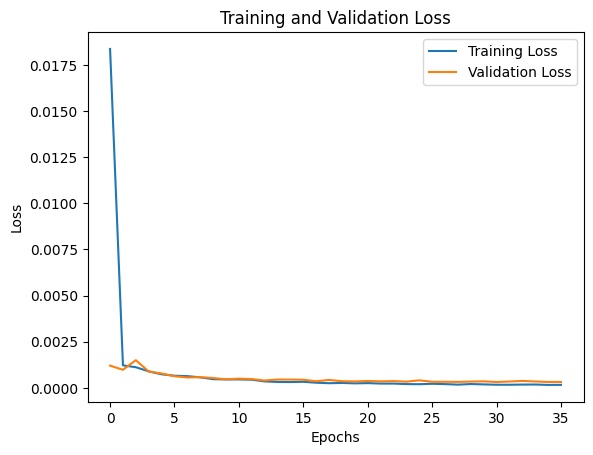

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 3.3986e-04 - mae: 0.0124


Validation Loss: 0.0003, Validation MAE: 0.0123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


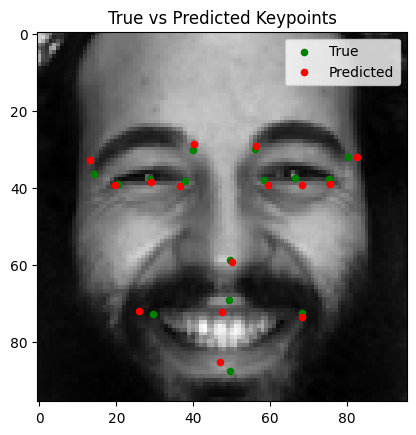

In [ ]:
#Attempt 3
def cnn_model2():
  model = tf.keras.Sequential()
  model.add(Input(shape=(96, 96, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
 # model.add(Dropout(0.20))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.20))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  #model.add(Dropout(0.50))
  model.add(Dense(30))
  model.summary()

  return model

from tensorflow.keras.callbacks import  *
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
# Compile the model
model = cnn_model2()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history3 = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es]
                    )
# Plot training history
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on validation data
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
visualize_predictions(0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


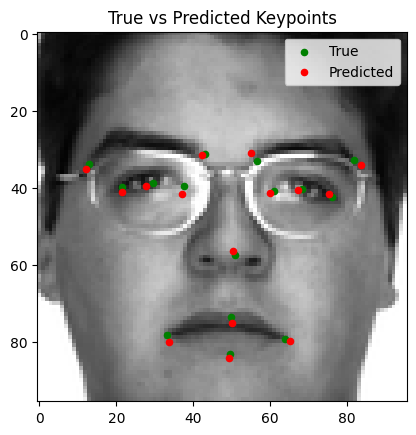

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


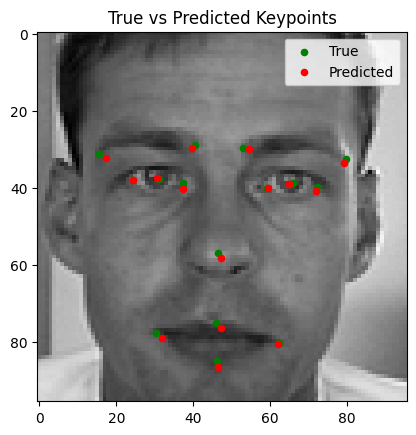

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


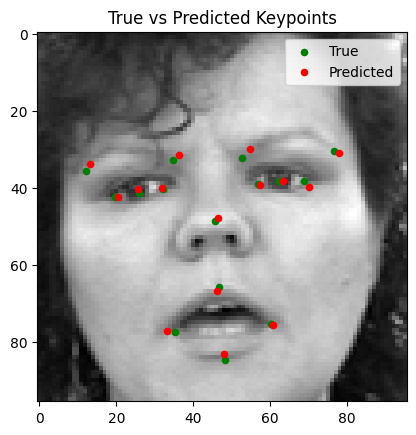

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


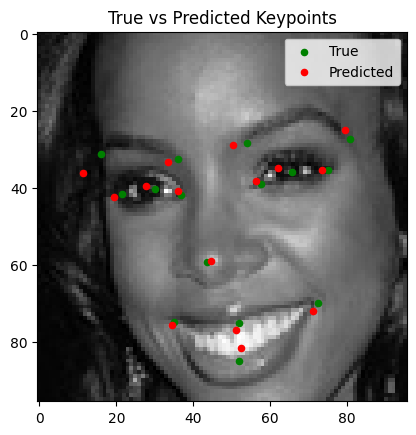

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


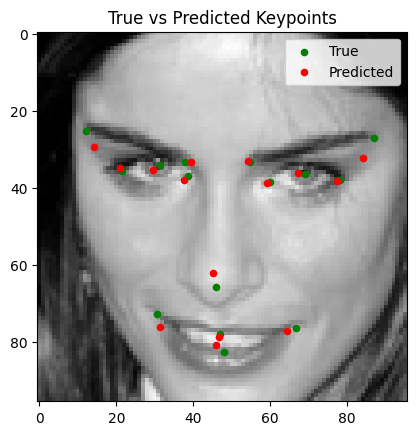

In [ ]:
import random
random_indices = np.random.choice(len(X_val), size = 5)
for index in random_indices:
  visualize_predictions(index)

The addtion of another increasing convoluting layer of filter size 128 in attempt 3 , improved the performance and decreased the error.

#### Optimizations
Experimented with a callback to systematically decrease the learning rate during training. I also tried reducing the batch size.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,070 (6.62 MB)

 Trainable params: 1,735,070 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - loss: 0.0330 - mae: 0.1117 - val_loss: 0.0012 - val_mae: 0.0254 - learning_rate: 0.0010
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0011 - val_mae: 0.0253 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 46s 372ms/step - loss: 8.9896e-04 - mae: 0.0224 - val_loss: 6.2851e-04 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 44s 402ms/step - loss: 6.2114e-04 - mae: 0.0183 - val_loss: 0.0010 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 71s 306ms/step - loss: 6.3359e-04 - mae: 0.0186 - val_loss: 5.0647e-04 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - loss: 4.5573e-04 - mae: 0.0158 - val_loss: 0.0010 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - loss: 5.7651e-04 - mae: 0.0178 - val_loss: 5.1078

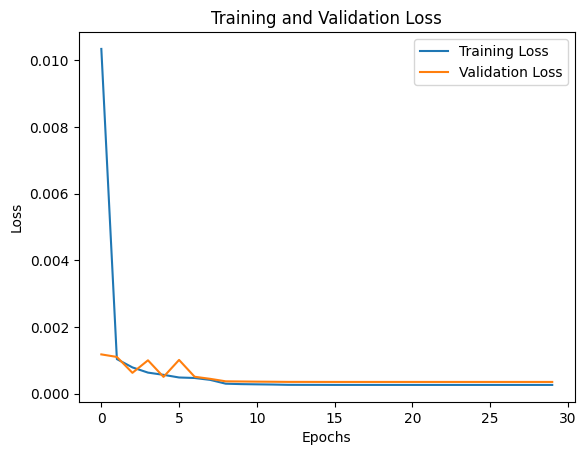

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 3.8494e-04 - mae: 0.0134
Validation Loss: 0.0004, Validation MAE: 0.0131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


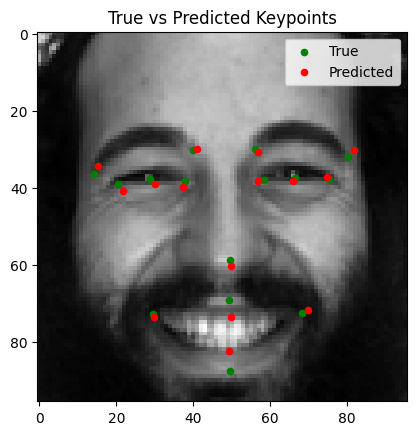

In [ ]:
# reducing learning rate and batch size
from tensorflow.keras.callbacks import  *
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
rop = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=3, verbose=1)

# Compile the model
model = cnn_model2()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[es,rop]
                    )
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
visualize_predictions(0)

Concluded that the implementation of the additional callback to reduce the learning rate was suboptimal as it weakend the performance and increased the error.

### Attempt 4: Data Augmentation
To improve model generalization and robustness, we experimented with introducing augmentation layers to the existing model architecture.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,070 (6.62 MB)

 Trainable params: 1,735,070 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 795ms/step - loss: 0.0563 - mae: 0.1626 - val_loss: 0.0026 - val_mae: 0.0400
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 609ms/step - loss: 0.0022 - mae: 0.0358 - val_loss: 0.0013 - val_mae: 0.0269
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 638ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 0.0013 - val_mae: 0.0269
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 901ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0010 - val_mae: 0.0235
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 610ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 609ms/step - loss: 0.0012 - mae: 0.0252 - val_loss: 0.0011 - val_mae: 0.0250
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 652ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 9.4793e-04 - val_mae: 0.0227
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 655ms/step - loss: 9.9938e-04 - mae: 0.0233 - val_loss: 0.0010 - val_mae: 0.0237
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38

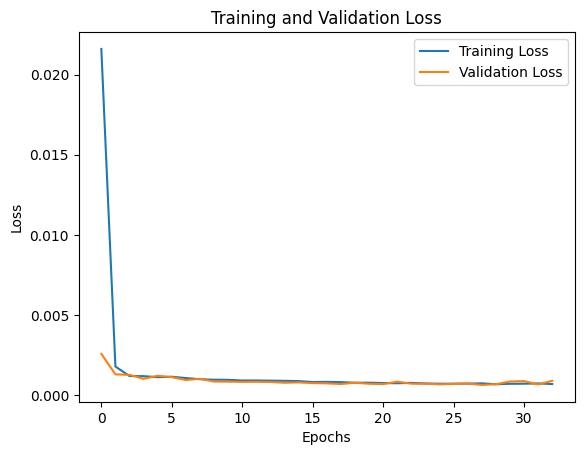

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 6.7686e-04 - mae: 0.0189
Validation Loss: 0.0006, Validation MAE: 0.0186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


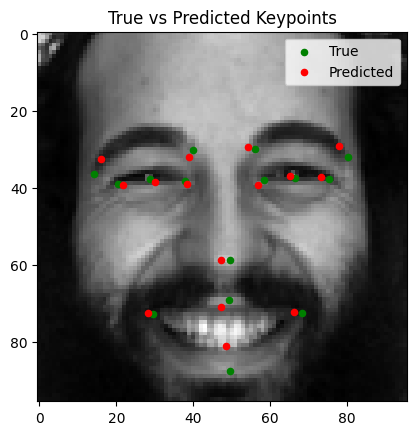

In [ ]:
#Attempt 4
def augmentation_model():
  model = tf.keras.Sequential()
  model.add(Input(shape=(96, 96, 1)))
  model.add(RandomFlip("horizontal"))
  model.add(RandomRotation(0.1))
  model.add(RandomZoom(0.1))
  model.add(RandomContrast(0.1))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
 # model.add(Dropout(0.20))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  #model.add(Dropout(0.20))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  #model.add(Dropout(0.50))
  model.add(Dense(30))
  model.summary()

  return model

from tensorflow.keras.callbacks import  *
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
# Compile the model
model5 = augmentation_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es]
                    )
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")
visualize_predictions(0)

I concluded that the attempt to add augmentation to the model Attempt 4, was suboptimal as it weakend the performance and increased the error. This is possibly because the chosen combination of augmentations was not the best.

# Model 2
Conducted by Alan Gonzalez

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Preparing the training data

In [ ]:
training_data = pd.read_csv('training.csv')

training_data.dropna(inplace=True)

def process_image_data(image_str):
  return np.fromstring(image_str, sep=' ')

def reshape_image(image_array):
  return image_array.reshape(96, 96)

'''
  FOR IMAGE INPUTS
'''


training_data['Image'] = training_data['Image'].map(process_image_data)

training_data['Image'] = training_data['Image'].map(reshape_image)

training_images = np.stack(training_data['Image'].to_numpy())

# Normalize pixel values to the range [0, 1]
training_images = training_images / 255.0

'''
  FOR COORDINATE OUTPUTS
'''
coordinate_columns = training_data.columns.difference(['Image'])

training_coordinates = training_data[coordinate_columns].to_numpy()

# Normalize coordinates to the range [0,1]
training_coordinates /= 96.0

Visualize for sanity. With and without keypoints.

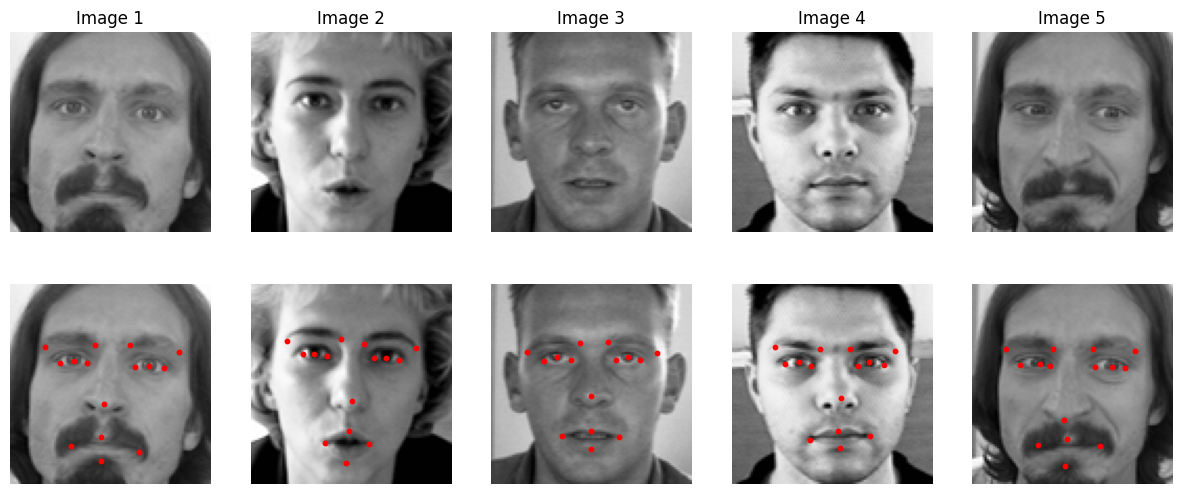

In [ ]:
# Number of examples to display
num_examples = 5

# Set up the figure with two rows: one for images, one for images with keypoints
fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))

for i in range(num_examples):
    # Select an image and its keypoints
    image = training_images[i]
    keypoints = training_coordinates[i] * 96.0

    # First row: Display the image without keypoints
    ax = axes[0, i]
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Turn off the axis
    ax.set_title(f"Image {i+1}")

    # Second row: Display the image with keypoints
    ax = axes[1, i]
    ax.imshow(image, cmap='gray')
    for j in range(0, len(keypoints), 2):  # Loop through x, y pairs
        x = keypoints[j]
        y = keypoints[j + 1]
        ax.scatter(x, y, c='red', s=10)  # Plot keypoints as red dots
    ax.axis('off')  # Turn off the axis

# Adjust layout to avoid overlap
plt.show()

Create a 80/20 split on the training data, only use test data to visually compare after training.

In [ ]:
split_index = int(len(training_images) * 0.8)

x_train = training_images[:split_index]
x_test = training_images[split_index:]
y_train = training_coordinates[:split_index]
y_test = training_coordinates[split_index:]

print('Training inputs shape:', x_train.shape)
print('Validation input shape:', x_test.shape)
print('Training outputs shape:', y_train.shape)
print('Validation output shpe:', y_test.shape)

Training inputs shape: (1712, 96, 96)
Validation input shape: (428, 96, 96)
Training outputs shape: (1712, 30)
Validation output shpe: (428, 30)


New dataset was severely affected by the removal of null/nan values, but
fabricating new values to replace the nulls seemed like a worse idea just to get more "data".

**[Attempt 1]**


Creating a simple convolutional model with 32, 16, and 8 filters. Adding option to modify filters if needed.

In [ ]:
def m2_simple_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [ ]:
m2_attempt_1 = m2_simple_convolution()
m2_attempt_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │       2,211,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,217,974 (8.46 MB)

 Trainable params: 2,217,974 (8.46 MB)

 Non-trainable params: 0 (0.00 B)

Create a loss function that measures the distances between the predicted and actual values. Using euclidean distances from the first homework.

In [ ]:
def m2_euclidean_distance_loss(predicted, actual):
  differences = actual - predicted
  squared_differences = tf.square(differences)
  squared_distances = tf.reduce_sum(squared_differences, axis = 1)
  distances = tf.sqrt(squared_distances)
  return tf.reduce_mean(distances)

Compile the model with the distance loss function. Using the adam optimizer because its commonly used.

In [ ]:
m2_attempt_1.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss,
)

Training the model with the obtained training and validation data. First try showed that the dataset had null values, so I had to remove them on the preparation.

In [ ]:
m2_attempt_1_history = m2_attempt_1.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 31s 666ms/step - loss: 3.0731 - val_loss: 3.6838
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 40s 669ms/step - loss: 3.6684 - val_loss: 3.6838
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 41s 683ms/step - loss: 3.6672 - val_loss: 3.6838
Epoch 4/50
33/43 ━━━━━━━━━━━━━━━━━━━━ 6s 619ms/step - loss: 3.6671

KeyboardInterrupt: 

Attempt abandoned due to long training time.

**[Attempt 2]**

Reduce the number of parameters needed to reduce training time. Idea: Add average pooling to reduce dimensions.

In [ ]:
def m2_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [ ]:
m2_attempt_2 = m2_convolution()
m2_attempt_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 12, 12, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

**Adding early stopping**
Decided to add the callback since attempt 2 validation loss was not improving significantly, to save time.

In [ ]:
m2_attempt_2.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_2_history = m2_attempt_2.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - loss: 0.5171 - val_loss: 0.2124
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.1610 - val_loss: 0.2021
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - loss: 0.1516 - val_loss: 0.1928
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.1410 - val_loss: 0.1847
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.1290 - val_loss: 0.1868
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.1269 - val_loss: 0.1741
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - loss: 0.1145 - val_loss: 0.1709
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - loss: 0.1092 - val_loss: 0.1673
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 0.1013 - val_loss: 0.1625
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - loss: 0.0984 - val_loss: 0.1574
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - loss: 0.0919 - val_loss: 0.1571
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s

Bringing the method to plot loss from previous homeworks.

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

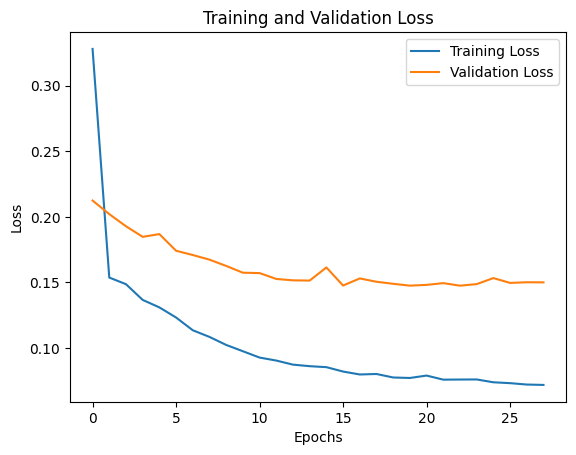

In [ ]:
plot_loss(m2_attempt_2_history)

The loss behavior seems extremely unusual, lets check out the predictions.

In [ ]:
def m2_evaluate_model(model):
  indices = [0,1,2]

  example_images = x_test[indices]

  true_keypoints = y_test[indices]
  predicted_keypoints = model.predict(example_images)

  # Rescale for image use
  true_keypoints *= 96.0
  predicted_keypoints *= 96.0

  print('True Keypoints:')

  fig, axes = plt.subplots(1, len(indices), figsize=(15, 6))

  for i in range(len(indices)):
      ax = axes[i]
      ax.imshow(example_images[i], cmap='gray')

      # Plot true keypoints
      ax.scatter(true_keypoints[i][::2], true_keypoints[i][1::2],
                c='green', s=10)

      ax.axis('off')

  plt.show()

  print('Predicted Keypoints:')

  fig, axes = plt.subplots(1, len(indices), figsize=(15, 6))

  for i in range(len(indices)):
    ax = axes[i]
    ax.imshow(example_images[i], cmap='gray')

    # Plot predicted keypoints
    ax.scatter(predicted_keypoints[i][::2], predicted_keypoints[i][1::2],
              c='red', s=10)

    ax.axis('off')

  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
True Keypoints:


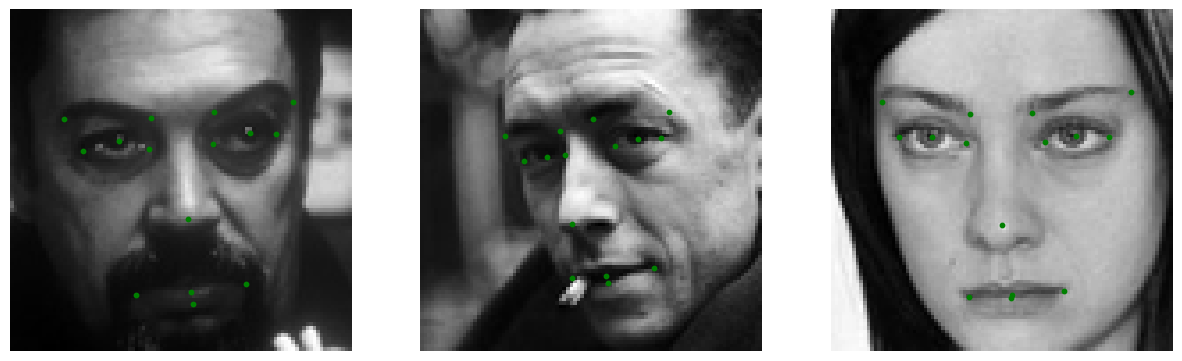

Predicted Keypoints:


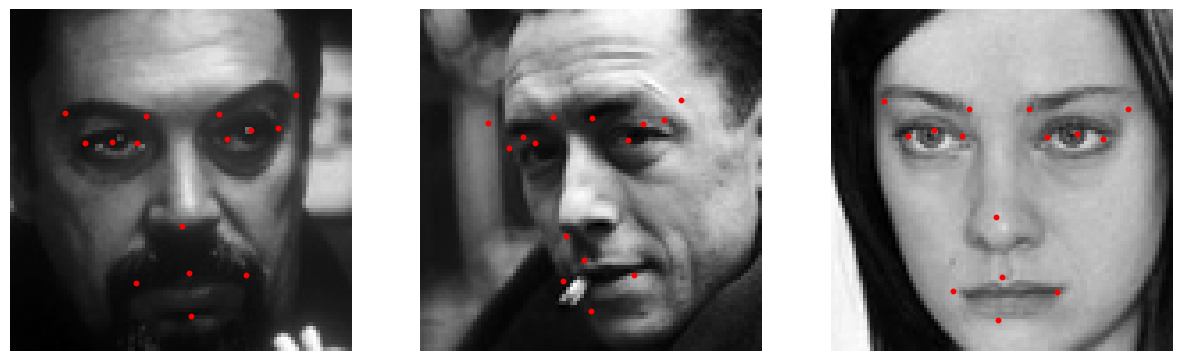

In [ ]:
m2_evaluate_model(m2_attempt_2)

It seems its placing the prediction keypoints in the same place for every image, lets check it out.

Define a function that prints all the predicted keypoints for x_test to see if there is a difference in the predictions or they are all the same.

In [ ]:
def plot_all_keypoint_predictions(model, x_test):
  predicted_keypoints_all = model.predict(x_test)

  predicted_keypoints_all *= 96.0

  fig, ax = plt.subplots(figsize=(3,3))

  for predicted_keypoints in predicted_keypoints_all:
    x_coords = predicted_keypoints[::2]
    y_coords = predicted_keypoints[1::2]

    # Invert y-coordinates
    y_coords = 96 - y_coords

    ax.scatter(x_coords, y_coords, s=10)

  # Set plot labels and title
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title("Predicted Keypoints for All Images")

  # Show the plot
  plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


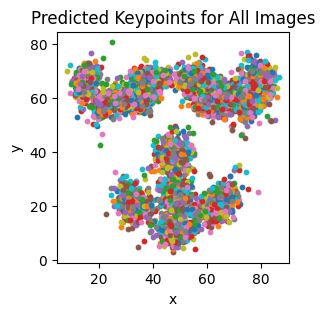

In [ ]:
plot_all_keypoint_predictions(m2_attempt_2, x_test)

The keypoints seem to always be in a certain area but with some variation,
maybe its the nature of the data.

Idea: add more data with augmentations

Rotation might be possible but too complicated or might require unfamiliar tools.

Horizontal flip possible.

In [ ]:
def flip_images_and_keypoints(input_images, output_keypoints):
  flipped_images = np.flip(input_images, axis = 2)

  flipped_keypoints = output_keypoints.copy()

  # Rescale
  flipped_keypoints *= 96

  for keypoints in flipped_keypoints:
    for i in range(0, 30, 2):
      keypoints[i] = 96 - keypoints[i]

  # Normalize
  flipped_keypoints /= 96.0

  return flipped_images, flipped_keypoints

Get a flipped set based on the training set.

In [ ]:
x_train_flipped, y_train_flipped = flip_images_and_keypoints(x_train, y_train)

Observe the outputs

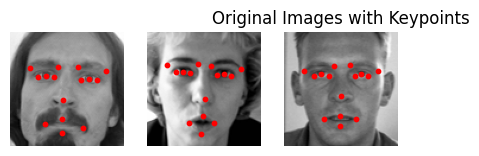

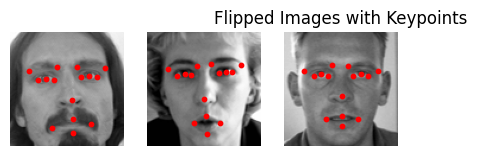

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(5,5))
plt.title("Original Images with Keypoints")

for i in range(3):
  ax[i].imshow(x_train[i], cmap='gray')
  ax[i].axis('off')
  ax[i].scatter(y_train[i][::2] * 96.0, y_train[i][1::2] * 96.0, c='red', s=10)

plt.show()


fig, ax = plt.subplots(1, 3, figsize=(5,5))
plt.title("Flipped Images with Keypoints")

for i in range(3):
  ax[i].imshow(x_train_flipped[i], cmap='gray')
  ax[i].axis('off')
  ax[i].scatter(y_train_flipped[i][::2] * 96.0, y_train_flipped[i][1::2] * 96.0, c='red', s=10)

plt.show()

Create augmented data set. More augmentations like noise, brightness, and contrast will be added with layers.

In [ ]:
x_train_augmented = np.concatenate((x_train, x_train_flipped))
y_train_augmented = np.concatenate((y_train, y_train_flipped))

print('Augmented x train shape:', x_train_augmented.shape)
print('Augmented y train shape:', y_train_augmented.shape)

Augmented x train shape: (3424, 96, 96)
Augmented y train shape: (3424, 30)


**[Attempt 3]**
Add remaning augmentations to the previous model.

In [ ]:
def m2_augmented_convolution(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  model.add(tf.keras.layers.RandomBrightness(factor=0.2))

  model.add(tf.keras.layers.RandomContrast(factor=0.2))

  model.add(tf.keras.layers.GaussianNoise(stddev=0.05))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [ ]:
m2_attempt_3 = m2_augmented_convolution()
m2_attempt_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness (RandomBrightness) │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 48, 48, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 12, 12, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
m2_attempt_3.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_3_history = m2_attempt_3.fit(
  x = x_train_augmented,
  y = y_train_augmented,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - loss: 1.3562 - val_loss: 1.2716
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - loss: 0.8565 - val_loss: 1.3423
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - loss: 0.6768 - val_loss: 1.3355
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - loss: 0.6363 - val_loss: 1.3839
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - loss: 0.6273 - val_loss: 1.3655
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - loss: 0.6350 - val_loss: 1.3630


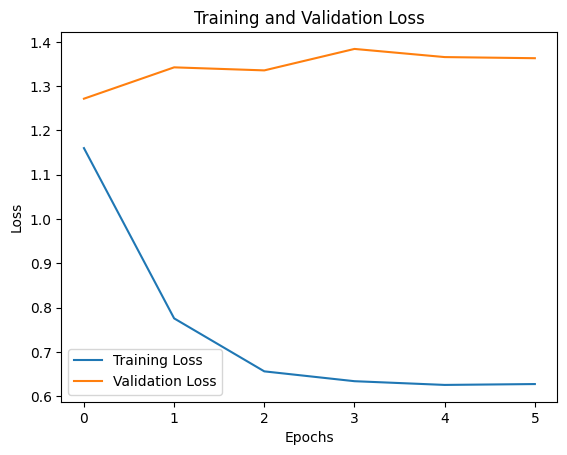

In [ ]:
plot_loss(m2_attempt_3_history)

The graph indicates immediate overfitting with very obvious plateaus.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
True Keypoints:


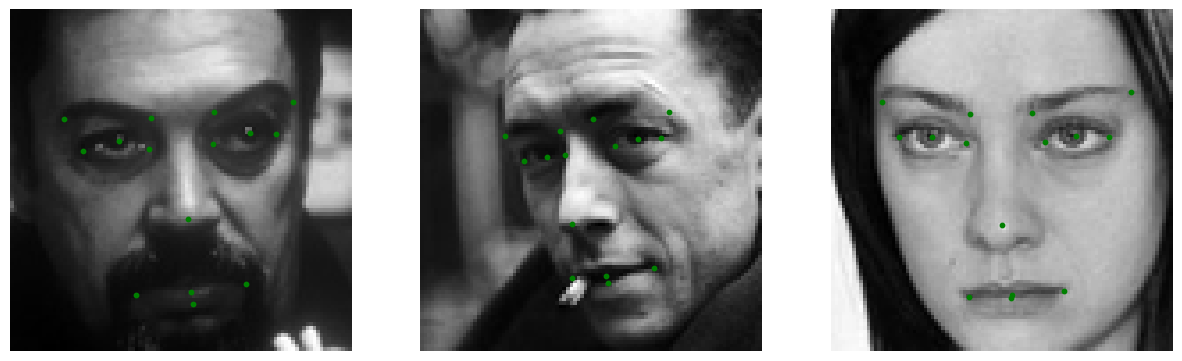

Predicted Keypoints:


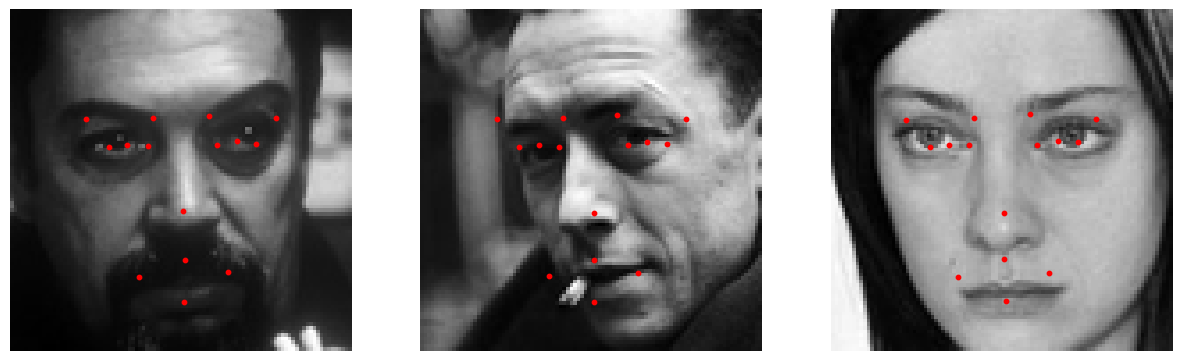

In [ ]:
m2_evaluate_model(m2_attempt_3)

Even though the validation loss seems higher, the visual results have more variation. Lets observe overall spread.

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


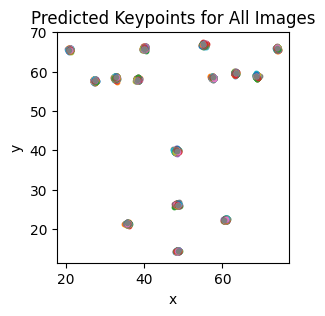

In [ ]:
plot_all_keypoint_predictions(m2_attempt_3, x_test)

The spread shows the predictions are not as spread out which confirms the overfitting.

**[Attempt 4]**

Idea: Adding dropout and activations. Remove flip augmentation.

In [ ]:
def m2_convolution_2(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  model.add(tf.keras.layers.RandomBrightness(factor=0.2))

  model.add(tf.keras.layers.RandomContrast(factor=0.2))

  model.add(tf.keras.layers.GaussianNoise(stddev=0.05))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same',
        activation = 'relu'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.AveragePooling2D(pool_size = (2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [ ]:
m2_attempt_4 = m2_convolution_2()
m2_attempt_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_1                  │ (None, 96, 96, 1)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_1 (GaussianNoise)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 48, 48, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 24, 24, 16)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 12, 12, 8)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

Train without x_train_augmented

In [ ]:
m2_attempt_4.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_4_history = m2_attempt_4.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 422ms/step - loss: 0.9796 - val_loss: 0.4981
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step - loss: 0.2383 - val_loss: 0.1893
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 301ms/step - loss: 0.1756 - val_loss: 0.1911
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 248ms/step - loss: 0.1706 - val_loss: 0.1917
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 297ms/step - loss: 0.1701 - val_loss: 0.1893
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - loss: 0.1646 - val_loss: 0.1909
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - loss: 0.1623 - val_loss: 0.1913
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - loss: 0.1619 - val_loss: 0.1909
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - loss: 0.1596 - val_loss: 0.1920
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - loss: 0.1587 - val_loss: 0.1915


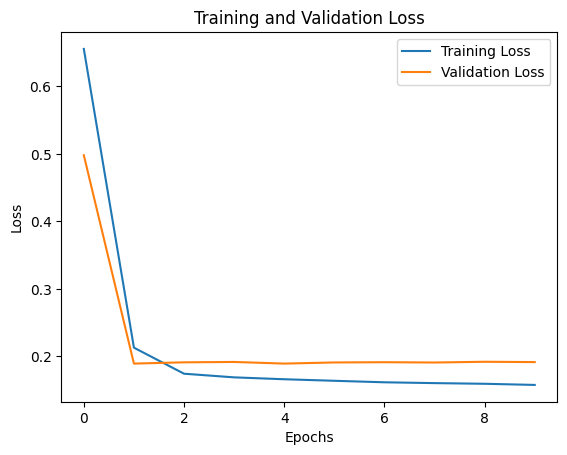

In [ ]:
plot_loss(m2_attempt_4_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
True Keypoints:


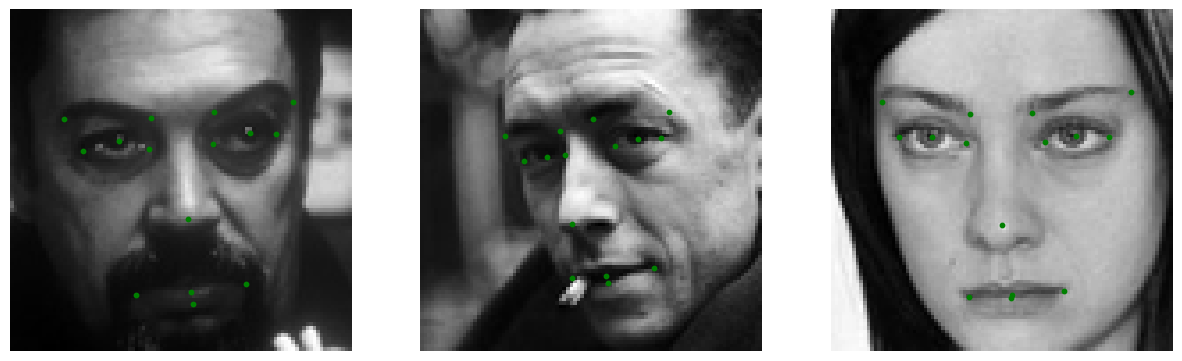

Predicted Keypoints:


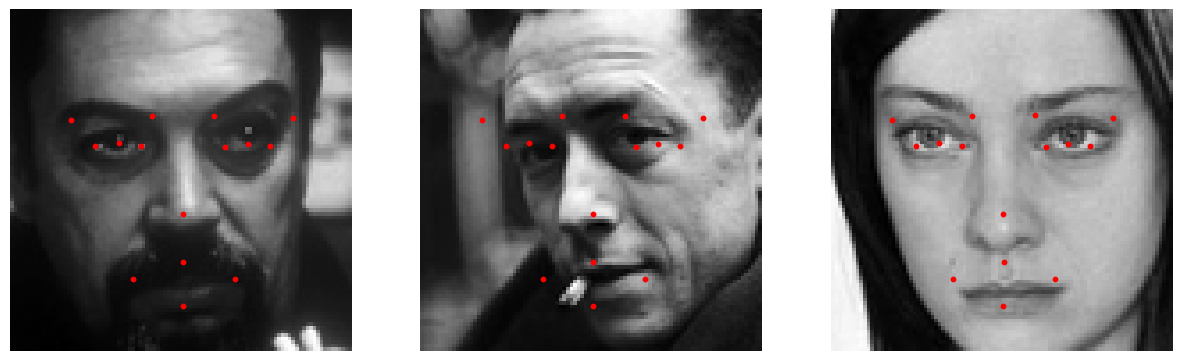

In [ ]:
m2_evaluate_model(m2_attempt_4)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


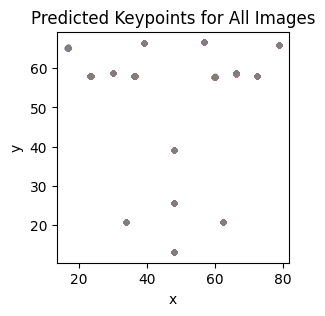

In [ ]:
plot_all_keypoint_predictions(m2_attempt_4, x_test)

New points seem extremely focused which might be bad.

**[Attempt 5]**

Idea: Swap average pooling by max pooling.

In [ ]:
def m2_convolution_3(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  model.add(tf.keras.layers.RandomBrightness(factor=0.2))

  model.add(tf.keras.layers.RandomContrast(factor=0.2))

  model.add(tf.keras.layers.GaussianNoise(stddev=0.05))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same',
        activation = 'relu'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [ ]:
m2_attempt_5 = m2_convolution_3()
m2_attempt_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness_2                  │ (None, 96, 96, 1)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_2 (RandomContrast)   │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_2 (GaussianNoise)     │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
m2_attempt_5.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_5_history = m2_attempt_5.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - loss: 1.0207 - val_loss: 0.7230
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 346ms/step - loss: 0.2975 - val_loss: 0.2188
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - loss: 0.1820 - val_loss: 0.1956
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - loss: 0.1732 - val_loss: 0.1903
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - loss: 0.1682 - val_loss: 0.1890
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - loss: 0.1634 - val_loss: 0.1915
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - loss: 0.1625 - val_loss: 0.1911
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - loss: 0.1591 - val_loss: 0.1920
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 350ms/step - loss: 0.1573 - val_loss: 0.1895
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step - loss: 0.1589 - val_loss: 0.1889
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 354ms/step - loss: 0.1594 - val_loss: 0.1895
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20

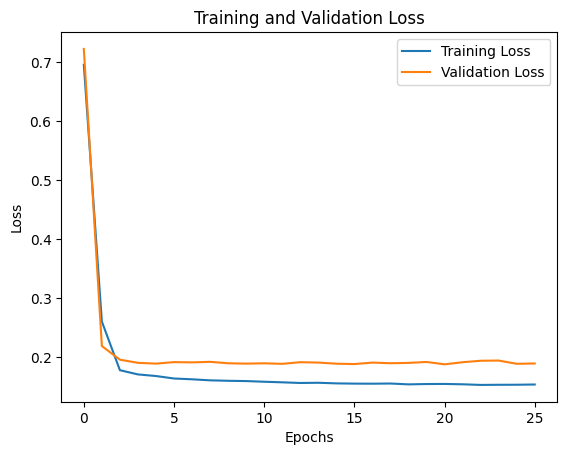

In [ ]:
plot_loss(m2_attempt_5_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
True Keypoints:


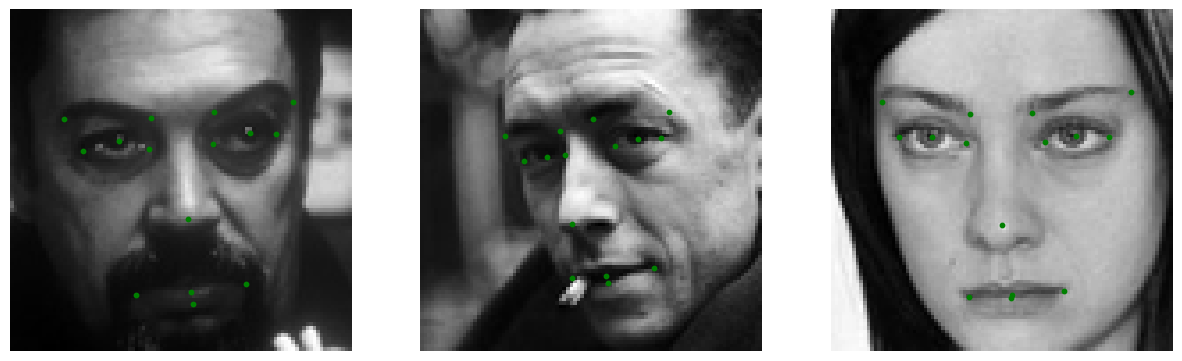

Predicted Keypoints:


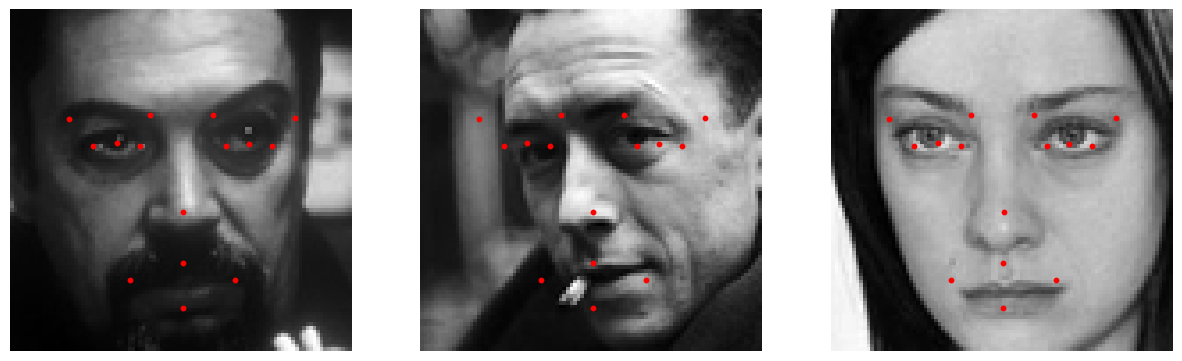

In [ ]:
m2_evaluate_model(m2_attempt_5)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


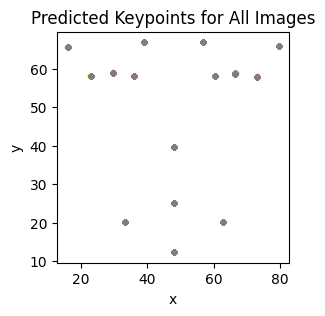

In [ ]:
plot_all_keypoint_predictions(m2_attempt_5, x_test)

**[Attempt 6]**

Adding activations to the most successful model, using augmented data set, and max pooling.

In [ ]:
def m2_convolution_4(filters = [32, 16, 8]):
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Input(shape = (96, 96, 1)))

  for num_filters in filters:
    model.add(
      tf.keras.layers.Conv2D(
        num_filters,
        kernel_size = (3, 3),
        padding = 'same',
        activation = 'relu'
      )
    )

    # Reduce size by half
    model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(30, activation = 'sigmoid'))

  return model

In [ ]:
m2_attempt_6 = m2_convolution_4()
m2_attempt_6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 96, 96, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 48, 48, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │          34,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,694 (158.96 KB)

 Trainable params: 40,694 (158.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
m2_attempt_6.compile(
  optimizer = 'adam',
  loss = m2_euclidean_distance_loss
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor = 'val_loss',
  patience = 5,
)

m2_attempt_6_history = m2_attempt_6.fit(
  x = x_train,
  y = y_train,
  validation_split = 0.2,
  epochs = 50,
  batch_size = 32,
  verbose = 1,
  callbacks = [early_stopping]
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 425ms/step - loss: 0.5377 - val_loss: 0.2028
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step - loss: 0.1568 - val_loss: 0.1919
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 278ms/step - loss: 0.1399 - val_loss: 0.1872
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 317ms/step - loss: 0.1338 - val_loss: 0.1741
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - loss: 0.1188 - val_loss: 0.1625
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - loss: 0.1025 - val_loss: 0.1600
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - loss: 0.0968 - val_loss: 0.1515
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - loss: 0.0903 - val_loss: 0.1478
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - loss: 0.0843 - val_loss: 0.1415
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - loss: 0.0807 - val_loss: 0.1420
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - loss: 0.0794 - val_loss: 0.1383
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20

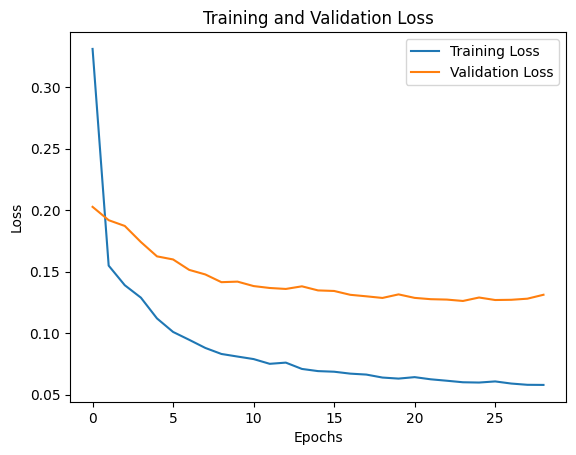

In [ ]:
plot_loss(m2_attempt_6_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
True Keypoints:


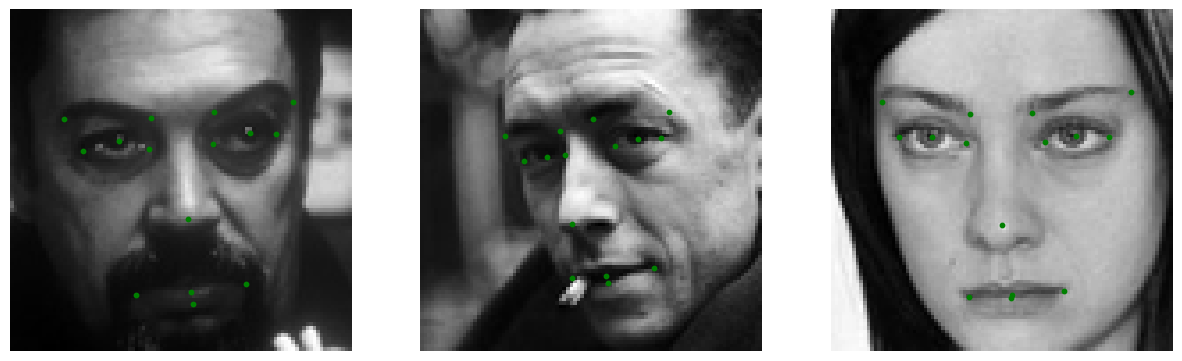

Predicted Keypoints:


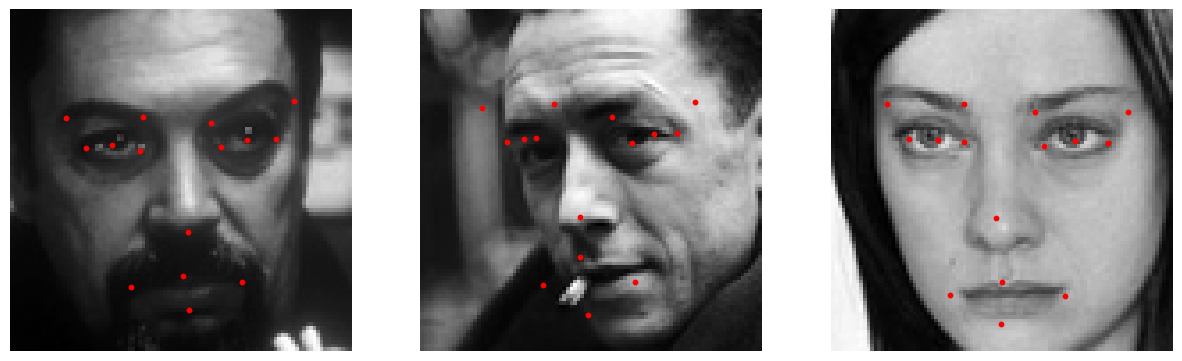

In [ ]:
m2_evaluate_model(m2_attempt_6)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


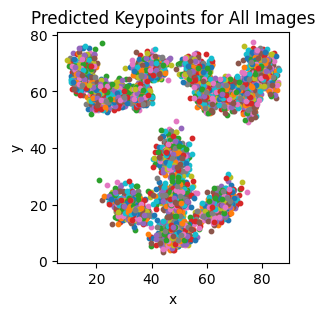

In [ ]:
plot_all_keypoint_predictions(m2_attempt_6, x_test)

# FINAL MODEL

We observed that increasing filter convolution without augmentations shows the best performance even
if the number of parameters and training time increases. Mean squared error even though
not a distance formula, does help reduce with distance related cases.

Preparing for the final model

The same preparations will be used but using the test data to visualize results.
- Removing null examples
- Normalizing images and keypoints

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import  *

In [4]:
training_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')

training_data.dropna(inplace=True)
test_data.dropna(inplace=True)

def process_image_data(image_str):
  return np.fromstring(image_str, sep=' ')

def reshape_image(image_array):
  return image_array.reshape(96, 96)

# Prepare training data
training_data['Image'] = training_data['Image'].map(process_image_data)
training_data['Image'] = training_data['Image'].map(reshape_image)
x_train = np.stack(training_data['Image'].to_numpy())
x_train /= 255.0
training_keypoint_columns = training_data.columns.difference(['Image'])
y_train = training_data[training_keypoint_columns].to_numpy()
y_train /= 96.0

# Prepare test data
test_data['Image'] = test_data['Image'].map(process_image_data)
test_data['Image'] = test_data['Image'].map(reshape_image)
x_test = np.stack(test_data['Image'].to_numpy())
x_test /= 255.0

After evaluating multiple attempts, we chose the same architecture of  Model 1 Attempt 3 for our final model due to its strong performance and robust generalization capabilities.

In [5]:
def final_model():
  model = tf.keras.Sequential()

  model.add(Input(shape = (96, 96, 1)))

  for num_filters in [32, 64, 128]:
    model.add(Conv2D(
      num_filters,
      kernel_size = (3, 3),
      activation = 'relu',
    ))

    model.add(MaxPooling2D(pool_size = (2, 2)))


  model.add(Flatten())
  model.add(Dense(128, activation = 'relu'))
  model.add(Dense(30, activation = 'sigmoid'))

  return model

In [7]:
final_model = final_model()
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,070 (6.62 MB)

 Trainable params: 1,735,070 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(monitor = 'loss', verbose = 1, patience = 5, restore_best_weights = True)

final_model.compile(
  optimizer = 'adam',
  loss = 'mean_squared_error', metrics=['mae']
)

final_history = final_model.fit(
  x_train,
  y_train,
  epochs = 50,
  batch_size = 32,
  callbacks = [early_stopping]
)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 561ms/step - loss: 9.1744e-04 - mae: 0.0210
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 531ms/step - loss: 1.2856e-04 - mae: 0.0083
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - loss: 1.1335e-04 - mae: 0.0078
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 36s 538ms/step - loss: 1.0932e-04 - mae: 0.0077
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 517ms/step - loss: 1.1646e-04 - mae: 0.0080
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 543ms/step - loss: 1.0652e-04 - mae: 0.0076
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 516ms/step - loss: 1.0152e-04 - mae: 0.0075
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 38s 567ms/step - loss: 9.5940e-05 - mae: 0.0072
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 507ms/step - loss: 1.0081e-04 - mae: 0.0075
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 518ms/step - loss: 9.9690e-05 - mae: 0.0073
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 543ms/step - loss: 9.2724e-05 - mae: 0.0072
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 517ms/ste

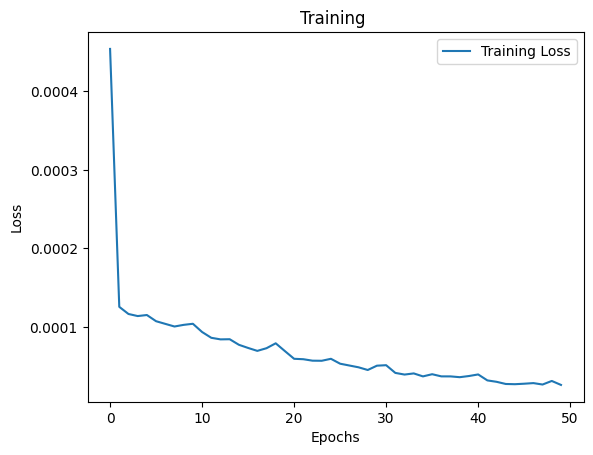

In [10]:
plt.plot(final_history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training ')
plt.show()



Visualization of predicted keypoints on random test images from the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Predicted Keypoints:


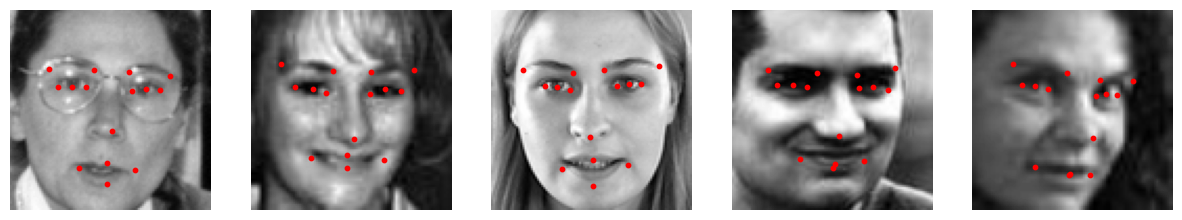

In [13]:
#indices = [0,1,2]
import random
indices = np.random.choice(len(x_test), size = 5)

example_images = x_test[indices]

predicted_keypoints = final_model.predict(example_images)

# Rescale for image use\
predicted_keypoints *= 96.0

print('Predicted Keypoints:')

fig, axes = plt.subplots(1, len(indices), figsize=(15, 6))

for i in range(len(indices)):
  ax = axes[i]
  ax.imshow(example_images[i], cmap='gray')

  # Plot predicted keypoints
  ax.scatter(predicted_keypoints[i][::2], predicted_keypoints[i][1::2],
            c='red', s=10)

  ax.axis('off')

plt.show()

Predicting the keypoints for all samples in test set

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step


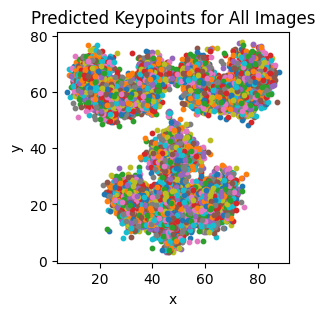

In [ ]:
predicted_keypoints_all = final_model.predict(x_test)

predicted_keypoints_all *= 96.0

fig, ax = plt.subplots(figsize=(3,3))

for predicted_keypoints in predicted_keypoints_all:
  x_coords = predicted_keypoints[::2]
  y_coords = predicted_keypoints[1::2]

  # Invert y-coordinates
  y_coords = 96 - y_coords

  ax.scatter(x_coords, y_coords, s=10)

# Set plot labels and title
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Predicted Keypoints for All Images")

# Show the plot
plt.show()

# Conclusion:

We successfully achieved the objective of developing a model that accurately predicts facial keypoints with strong generalization and minimal error. The model's performance, demonstrated through low validation loss, low MAE, and close alignment between true and predicted keypoints, indicates its reliability and precision.

The results highlight the potential real-world applications of this model, such as in facial recognition systems or medical imaging analysis, particularly for identifying medical conditions that affect facial features, such as strokes or other disorders causing facial abnormalities.

Next Steps
Building on this work, future efforts could explore:
1. Predicting additional attributes like gender and age using facial keypoints.
2. Developing models to identify specific individuals based on unique facial landmarks.
3. Expanding the dataset to include more diverse facial variations, enabling further refinement and robustness of the model.

This progression could make the model even more versatile and impactful in both healthcare and security domains.

